# Stock Market Prediction Using Financial News and Historical Data

Using sentiment analysis and recurrent neural network models (LSTM)
we combine ”public sentiment” and historical market data to find a predictor for ”market movment”. We use financial news datasets from Reuters to predict public mood given by the sentiment of the news headline. In addition, we use Dow Jones Industrial average closing price to predict next day movement. The model trained with time series features for the period '2006-10-20' to '2008-01-17' obtain ~%95 accuracy on the test set from '2008-01-17' to '2008-02-28 using the window size of 32 days.



## Financial news-data prepration

In [ ]:
import requests

DIR_NAME = 'ReutersNews106521'
def get_data(DIR_NAME):
    '''
    Get Reuters Finacial News Data Set 
    @ https://github.com/duynht/financial-news-dataset
    '''
    
    if not os.path.exists(DIR_NAME):
        os.mkdir(DIR_NAME)
    url = "https://github.com/duynht/financial-news-dataset/financial-news-dataset-master.zip"
    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(DIR_NAME, name), 'w') as f:
        f.write(response.content)


In [4]:
#Load and parse Reuters Finacial News Data Set @ https://github.com/duynht/financial-news-dataset
import os
import sys
DIR_NAME = 'ReutersNews106521'

def parse_date(DIR_NAME = 'ReutersNews106521', dir_limit = 500):
    
    '''
    parsing the news dataset folders and 
    extract news dates, titles and contents
    use small dir_limit arg to experiment first
    otherwise use full data set
    '''
    
    c = 0
    new_text = []
    titles = []
    dates = []
    contents = []

    for names in sorted(os.listdir(DIR_NAME)):
        c+=1
        path = os.path.join(DIR_NAME, names)
        if c < dir_limit:
            if os.path.isdir(path):
                for fname in sorted(os.listdir(path)):
                    fpath = os.path.join(path, fname)
                    if(not fpath.endswith('.DS_Store')):
                        with open(fpath, 'rb') as f:
                            t = f.read().decode('utf-8',errors='ignore')
                            new_text = t.split('\n-- ')
                            title, date, content = new_text[0].strip('--'), new_text[2], new_text[3] 
                            titles.append(title)
                            dates.append(date)
                            contents.append(content)
    return titles, dates, contents

titles, dates, contents =  parse_date('ReutersNews106521', sys.maxsize)

## Finding news sentiments

In [7]:
#Find News titles Sentiment using the updated lexicon of vaderSentiment
#To Do: add the news content for as the feature

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def sentiment_score_vade(sent):
    
    '''
    find the sentiment of news with the updated lexicon
    retruns: total poliarity of sentences (positve + negative + nuetral)
    '''
    
    sia = SentimentIntensityAnalyzer()
    new_words = {
        'crushes': 10,
        'beats': 5,
        'misses': -5,
        'trouble': -10,
        'falls': -100,
    }
    sia.lexicon.update(new_words)
    return sia.polarity_scores(sent)['compound']

## DataFrame preprarion

Pulling Dow Jones Industrial average and Mergeing/alingning with the sentiment data

In [8]:
#make a dataframe using dates and titles and the corosponding sentiment

import pandas as pd

df = pd.DataFrame({"date": dates, "title": titles})
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace = True)
df = df.sort_index()
df['sentiment'] = df.apply(sentiment_score_vade, axis = 1)

/opt/conda/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/opt/conda/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [123]:
df.head(10)

,title,sentiment,std_sentiment
date,,,
2006-10-20,"Hey buddy, can you spare $600 for a Google sh...",0.2960,NaN
2006-10-20,Exxon Mobil offers plan to end Alaska dispute,-0.4019,NaN
2006-10-21,AOL CEO says sales may shrink for two years -...,0.0000,NaN
2006-10-21,Pluspetrol says losing $2.4 mln/day in Peru p...,-0.5574,NaN
2006-10-22,EU to urge China to open economy further,0.0000,0.386141
2006-10-22,"Fed to keep hawkish tone, hold rates steady",0.0000,0.714546
2006-10-22,Weatherford profit jumps 78 percent,0.4404,1.308958
2006-10-22,Saudi Arabia tells Japan to cut its Nov crude...,-0.7003,-1.156541
2006-10-23,Australia's Foster's says confident on targets,0.4939,0.933414


In [13]:
df.index = df.index.strftime('%Y-%m-%d')

Index(['2006-10-20', '2006-10-20', '2006-10-21', '2006-10-21', '2006-10-22',
       '2006-10-22', '2006-10-22', '2006-10-22', '2006-10-23', '2006-10-23',
       ...
       '2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29',
       '2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29'],
      dtype='object', name='date', length=17028)

In [14]:
!pip install yfinance
import yfinance as yf 

In [15]:
# Getting historical data for Dow Jones Industrial Average index

ticker = 'DJI'
sdate = df.index[0]
edate = df.index[-1]

data = yf.download(ticker, sdate, edate)

[*********************100%***********************]  1 of 1 completed


In [116]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,12002.400391,0
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,12116.900391,0
2006-10-24,12127.900391,12127.900391,12127.900391,12127.900391,12127.900391,0
2006-10-25,12134.700195,12134.700195,12134.700195,12134.700195,12134.700195,0
2006-10-26,12163.700195,12163.700195,12163.700195,12163.700195,12163.700195,0


In [17]:
#Compute the standardize (centered by the mean and divided by std) 5-days rolling average of news sentiment

r_wind = 5 
tol = 0.0001
df['std_sentiment'] = (df['sentiment'] - df['sentiment'].rolling(r_wind).mean())/(df['sentiment'].rolling(r_wind).std()+tol)

In [120]:
df_mix_all.head()

,Open,High,Low,Close,Adj Close,Volume,std_sentiment
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,12002.400391,0,0.933414
2006-10-20,12002.400391,12002.400391,12002.400391,12002.400391,12002.400391,0,0.933414
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,12116.900391,0,0.933414
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,12116.900391,0,-0.097705
2006-10-23,12116.900391,12116.900391,12116.900391,12116.900391,12116.900391,0,-0.097705


In [119]:
df_mix_all = pd.merge(data, df[["std_sentiment"]], left_index = True, right_index = True)
df_mix_all.fillna(method='bfill', inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7932058f10>,
      dtype=object)

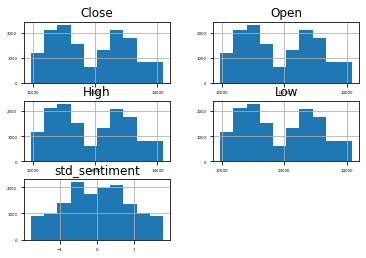

In [122]:
# Plot a histogram for few columns of the dataframe which shows the distribution of values
df_mix_all[["Close", "Open", "High", "Low", "std_sentiment"]].hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4)

In [18]:
#We use only "Close" price and news sentiments as features of our model
#Merge historical data and news sentiments and handle missing values

df_mix = pd.merge(data[["Close"]], df[["std_sentiment"]], left_index = True, right_index = True)
df_mix.fillna(method='bfill', inplace=True)

In [115]:
df_mix.describe()

,Close,std_sentiment
count,14569.000000,1.456900e+04
mean,12941.267878,-2.634303e-03
std,576.694432,8.857303e-01
min,11971.200195,-1.788454e+00
25%,12441.299805,-6.601949e-01
50%,12853.099609,-1.776357e-12
75%,13432.799805,6.553397e-01
max,14093.099609,1.788426e+00


In [20]:
# picle the mixed datafarme
df_mix.to_pickle("./data_mix.pkl")
import pandas as pd
# df_mix = pd.read_pickle('./data_mix.pkl')
# df_mix.head()

## Time series visualization

Text(0.5, 1.0, 'Dow Jones Industrial Average')

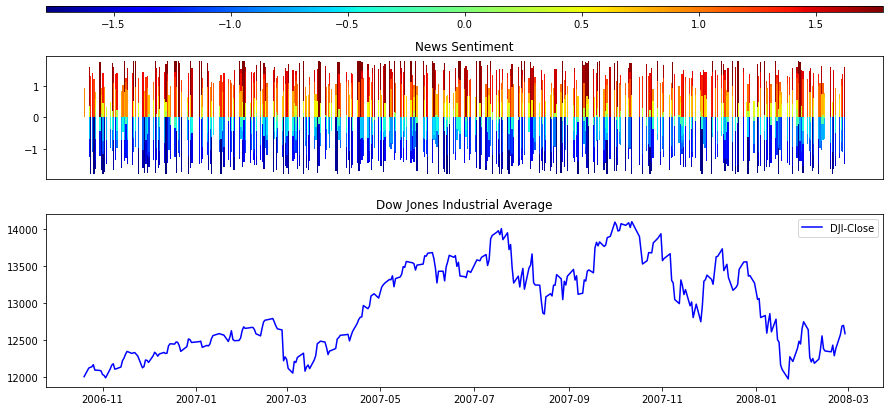

In [114]:
#visualizing the news sentiment and the historical data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mask_step = 4
my_cmap = cm.get_cmap('jet')
# my_cmap = cm.get_cmap('Spectral')
sent_vals = df_mix[['std_sentiment']].values[:, 0]
my_norm = Normalize(vmin=min(sent_vals), vmax=max(sent_vals))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
ax1.bar(df_mix.index.values[::mask_step], sent_vals[::mask_step], color = my_cmap(my_norm(sent_vals[::mask_step])), label = 'New-sentiment')
ax1.set_title('News Sentiment')
ax1.axes.xaxis.set_visible(False)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.6)
cax.xaxis.set_ticks_position("top")

fig.add_axes(cax)

plt.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap),
             cax=cax,
             orientation='horizontal', fraction=0.02,anchor=(1.0,0.0))


ax2.plot(df_mix.index, df_mix[["Close"]], c = 'b', label = 'DJI-Close')
ax2.legend()
ax2.set_title('Dow Jones Industrial Average')


## Data preperation for the LSTM network 

In [52]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
scaler = MinMaxScaler(feature_range=(0,1))

In [68]:

def scale_conform_data_series(df_mix, window = 32):
    '''
    Train and test time series features (news sentiment and DJIa) split by 90-10%
    '''
    
    df_2d_vals = df_mix.values
    scaler = MinMaxScaler(feature_range=(0,1))
    x2 = scaler.fit_transform(df_2d_vals[:, 1].reshape(-1,1))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(df_2d_vals[:, 0].reshape(-1, 1))
    x1 = scaler.transform(df_2d_vals[:, 0].reshape(-1, 1))
    
    x_size=x1.shape[0]
    x_train, x_test = np.c_[x1[:round(x_size*0.9)], x2[:round(x_size*0.9)]], np.c_[x1[round(x_size*0.9):], x2[round(x_size*0.9):]]
    x1_train, x1_test = x1[:round(x_size*0.9)], x1[round(x_size*0.9):]
    x1_train, x1_test = np.array(x1_train).reshape(-1, 1), np.array(x1_test).reshape(-1, 1)
    x_train_data, y_train_data, x1_train_data, y1_train_data=[], [], [], []

    for i in range(window, len(x_train)):
        x_train_data.append(x_train[i-window:i,:])
        x1_train_data.append(x1_train[i-window:i, 0])
        y_train_data.append(x_train[i,0])
        y1_train_data.append(x_train[i,0])
        
    x_train_data = np.array(x_train_data)
    x1_train_data = np.array(x1_train_data)
    x1_train_data = x1_train_data.reshape(x1_train_data.shape[0], x1_train_data.shape[1], 1)
    y_train_data = np.array(y_train_data).reshape(-1, 1)
    y1_train_data = np.array(y1_train_data).reshape(-1, 1)
    
    return x_train_data, x1_train_data, y_train_data, y1_train_data, x1_train, x1_test 

In [69]:
x_train_data, x1_train_data, y_train_data, y1_train_data, x1_train, x1_test = scale_conform_data_series(df_mix)

In [75]:
#building and training a shallow LSTM model. The model takes the historical time series and the scaled news 
# sentiment time-series in 32-days window  as input to predict the DJI avg-index for the next day.
# we can use LearningRateScheduler to find the optimal learning rate

#2D-model:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, input_shape = (x_train_data.shape[1], 2))))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(1))

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 10))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
model.compile(loss='mean_squared_error',optimizer='adam', metrics=["mae"])
# history = model.fit(x_train_data, y_train_data, epochs = 40, callbacks=[lr_schedule])
history = model.fit(x_train_data, y_train_data, epochs= 40)

Epoch 1/40
409/409 [==============================] - 18s 44ms/step - loss: 0.0046 - mae: 0.0270
Epoch 2/40
409/409 [==============================] - 17s 41ms/step - loss: 4.1057e-04 - mae: 0.0119
Epoch 3/40
409/409 [==============================] - 17s 41ms/step - loss: 2.6807e-04 - mae: 0.0085
Epoch 4/40
409/409 [==============================] - 17s 41ms/step - loss: 2.2962e-04 - mae: 0.0080
Epoch 5/40
409/409 [==============================] - 16s 40ms/step - loss: 1.9746e-04 - mae: 0.0070
Epoch 6/40
409/409 [==============================] - 17s 41ms/step - loss: 1.9811e-04 - mae: 0.0075
Epoch 7/40
409/409 [==============================] - 16s 39ms/step - loss: 1.6298e-04 - mae: 0.0059
Epoch 8/40
409/409 [==============================] - 17s 40ms/step - loss: 1.5941e-04 - mae: 0.0061
Epoch 9/40
409/409 [==============================] - 16s 40ms/step - loss: 1.5963e-04 - mae: 0.0065
Epoch 10/40
409/409 [==============================] - 17s 41ms/step - loss: 1.5046e-04 - mae: 

In [88]:
model.save("./saved_lstm_model.h5")

Text(0, 0.5, 'Men Absolute Error')

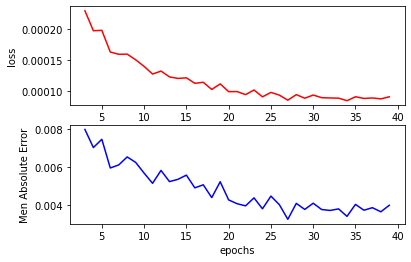

In [99]:
#plots of Loss and error fot the training rounds
st_ep = 3
fig, (ax_1, ax_2) = plt.subplots(2,1)
xrange = range(st_ep, len(history.history['loss']))
ax_1.plot(xrange, history.history['loss'][st_ep:], c = 'r')

ax_1.set_ylabel('loss')
ax_2.plot(xrange, history.history['mae'][st_ep:], c = 'b')
ax_2.set_xlabel('epochs')
ax_2.set_ylabel('Men Absolute Error')


(1e-08, 0.0001, 0.0, 30.0)

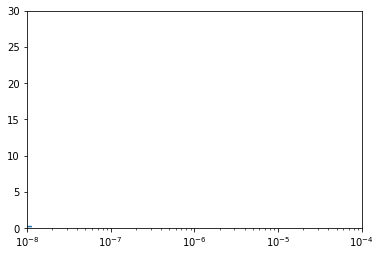

In [71]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [80]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#preparpe the test set sequence based on the window size of 32 days and inverse the preprocessing transformations

window = 32
X_test=[]
for i in range(window ,x_test.shape[0]):
    X_test.append(x_test[i-window:i,:])
X_test=np.array(X_test)

# X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted = model.predict(X_test)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_2d_vals[:, 0].reshape(-1, 1))
x1 = scaler.transform(df_2d_vals[:, 0].reshape(-1, 1))
predicted_inv = scaler.inverse_transform(predicted)
x1_train_inv = scaler.inverse_transform(x1_train)
x1_test_inv = scaler.inverse_transform(x1_test)
std_scaler = StandardScaler()

sent_vals_std = std_scaler.fit_transform(sent_vals.reshape(-1, 1))

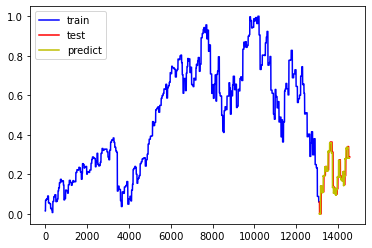

In [81]:
plt.plot(np.arange(len(x1_train)),x1_train[:,0], c='b', label = 'train')
plt.plot(np.arange(len(x1_train),len(x1_train)+len(x1_test)),x1_test[:,0], c='r', label = 'test')
plt.plot(np.arange(len(x1_train),len(x1_train)+len(predicted)),predicted[:,0], c='y', label = 'predict')
plt.legend()

## Visualizaing predictions 

Text(0.5, 1.0, 'Dow Jones Industrial Average')

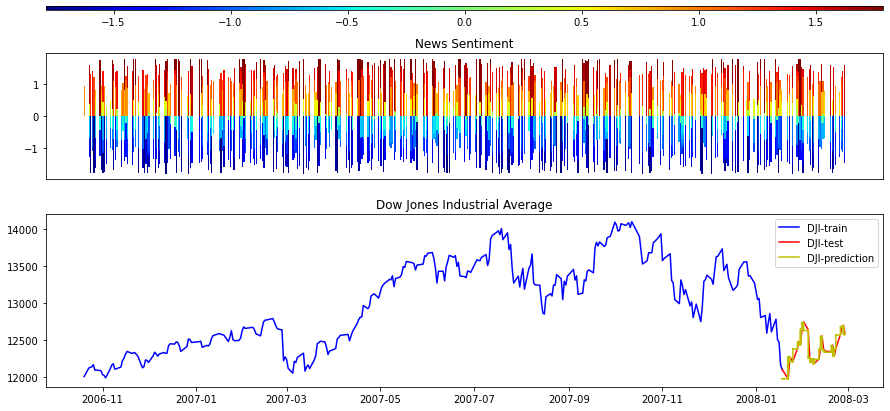

In [112]:
#Plotting the prediction results on the test set from '2008-01-17' to '2008-02-28 on the window size of 32 

mask_step = 4
my_cmap = cm.get_cmap('jet')
# my_cmap = cm.get_cmap('Spectral')
sent_vals = df_mix[['std_sentiment']].values[:, 0]
my_norm = Normalize(vmin=min(sent_vals), vmax=max(sent_vals))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
ax1.bar(df_mix.index.values[::mask_step], sent_vals[::mask_step], color = my_cmap(my_norm(sent_vals[::mask_step])), label = 'New-sentiment')
ax1.set_title('News Sentiment')
ax1.axes.xaxis.set_visible(False)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size=0.05, pad=.6)
cax.xaxis.set_ticks_position("top")
fig.add_axes(cax)

plt.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap),
             cax=cax,
             orientation='horizontal', fraction=0.02,anchor=(1.0,0.0))


ax2.plot(df_mix.index.values[:len(x1_train_inv)], x1_train_inv[:,0], c = 'b', label = 'DJI-train')
ax2.plot(df_mix.index.values[len(x1_train):len(x1_train)+len(x1_test)], x1_test_inv[:,0], c = 'r', label = 'DJI-test')
ax2.plot(df_mix.index.values[len(x1_train): len(x1_train)+len(predicted)], predicted_inv[:,0], c = 'y', label = 'DJI-prediction')
ax2.legend()
ax2.set_title('Dow Jones Industrial Average')



In [ ]:
# Alternative data_preperation for the LSTM network 

In [ ]:
train_size = 14569 - 500
train, test = df_mix[:train_size] , df_mix[train_size:]
train_v , test_v = train.values, test.values  
sc_train, sc_test = scaler.fit_transform(train_v), scaler.fit_transform(test_v)

In [ ]:
# using tensorflow to generate windowed datase. 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shift_v):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=shift_v, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + shift_v))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-shift_v], window[-shift_v:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

shift_v = 1

train_dataset = windowed_dataset(sc_train, window_size, batch_size, shuffle_buffer_size, shift_v)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None, None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(shift_v),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=10, callbacks=[lr_schedule])

In [ ]:
model.save("./saved_lstm_model.h5")

In [ ]:
series_len = 14569
forecast = []
results = []
for time in range(series_len - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]

In [ ]:
model.predict(series[time:time + window_size][np.newaxis])